# UAS Project Streamlit: 
- **Nama:** [Rakha Maulana]
- **Dataset:** [# Dataset Gambar Makanan
                Kue Indonesia                       : https://www.kaggle.com/datasets/ilhamfp31/kue-indonesia
                Makanan Indonesia                   : https://www.kaggle.com/datasets/theresalusiana/indonesian-food
                Kue Tradisional Indonesia           : https://www.kaggle.com/datasets/widyaameliaputri/indonesian-traditional-cakes
                Makanan Padang                      : https://www.kaggle.com/datasets/faldoae/padangfood
                Jajanan Tradisional Jawa Tengah     : https://www.kaggle.com/datasets/nizamkurniawan/jajanan-tradisional-jawa-tengah

                # Dataset Nutrition digunakan untuk mencari kandungan yang terdapat dalam suatu makanan
                https://www.kaggle.com/datasets/anasfikrihanif/indonesian-food-and-drink-nutrition-dataset

                # Dataset Kalori
                Dataset Kalori merupakan data pribadi yang didapat dari export aplikasi pelacak kebugaran yang digunakan oleh Taruna Rakha Maulana. Digunakan untuk memprediksi jarak lari berdasarkan informasi dari kalori yang telah diprediksi dari suatu makanan
            ]
- **URL Website:** [Di isi jika web streamlit di upload]



## Menentukan Pertanyaan Bisnis

- Dapatkah model kita secara akurat mengklasifikasikan jenis makanan dalam gambar berdasarkan dataset yang ada, dan berapa tingkat akurasi yang diharapkan?
- Pertanyaan 2

## Import Semua Packages/Library yang Digunakan

In [5]:
import os
import shutil
import matplotlib.pyplot as plt
from PIL import Image
import random
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.regularizers import L2
from keras_tuner.tuners import RandomSearch, Hyperband
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.utils import class_weight
import math
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputRegressor
import joblib
import pickle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


## Data Wrangling

### Gathering Data

In [6]:
train_dir = './train'
val_dir = './validation'
test_dir = './test'
tambahan = './dataset_tambahan/photos'
dest_dir = './Merged_Dataset'
os.makedirs(dest_dir, exist_ok=True)

In [7]:
file_path = 'Data.csv'
data = pd.read_csv(file_path)

#### Data Preparation

In [8]:
def copy_files_to_corresponding_subdirs(src_dir, dest_dir):
    for class_name in os.listdir(src_dir):
        dest_folder_class = os.path.join(dest_dir, class_name)
        os.makedirs(dest_folder_class, exist_ok=True)
        if not os.path.isdir(os.path.join(src_dir, class_name)):
            continue
        for file_name in os.listdir(os.path.join(src_dir, class_name)):
            if os.path.isdir(os.path.join(src_dir, class_name, file_name)):
                continue
            for dest_subdir_name in os.listdir(dest_dir):
                dest_subdir_path = os.path.join(dest_dir, dest_subdir_name)
                if not os.path.isdir(dest_subdir_path):
                    continue
                if dest_subdir_name == class_name:
                    shutil.copy(os.path.join(src_dir, class_name, file_name), os.path.join(dest_subdir_path, file_name))

copy_files_to_corresponding_subdirs(train_dir, dest_dir)
copy_files_to_corresponding_subdirs(val_dir, dest_dir)
copy_files_to_corresponding_subdirs(test_dir, dest_dir)
copy_files_to_corresponding_subdirs(tambahan, dest_dir)

### Assessing Data

In [9]:
def checkimages(dataset_dir,min_num_images):
    class_names = os.listdir(dataset_dir)
    for index,class_name in enumerate(class_names):
        class_dir = os.path.join(dataset_dir, class_name)
        num_images = len(os.listdir(class_dir))
        if num_images < min_num_images:
            print(f"{index} {class_name}: {num_images} images")
    print('-'*20)
checkimages(dest_dir, 180)

0 ayam_goreng: 147 images
30 telur_dadar: 156 images
--------------------


In [10]:
print(data.info())

# Count the number of missing values in each column
print("Number of missing values in each column:")
print(data.isnull().sum())

# Count the number of duplicated rows
num_duplicates = data.duplicated().sum()
print("Number of duplicated rows:", num_duplicates)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         303 non-null    object
 1   steps        303 non-null    int64 
 2   distance     303 non-null    int64 
 3   runDistance  303 non-null    int64 
 4   calories     303 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 12.0+ KB
None
Number of missing values in each column:
date           0
steps          0
distance       0
runDistance    0
calories       0
dtype: int64
Number of duplicated rows: 0


### Cleaning Data

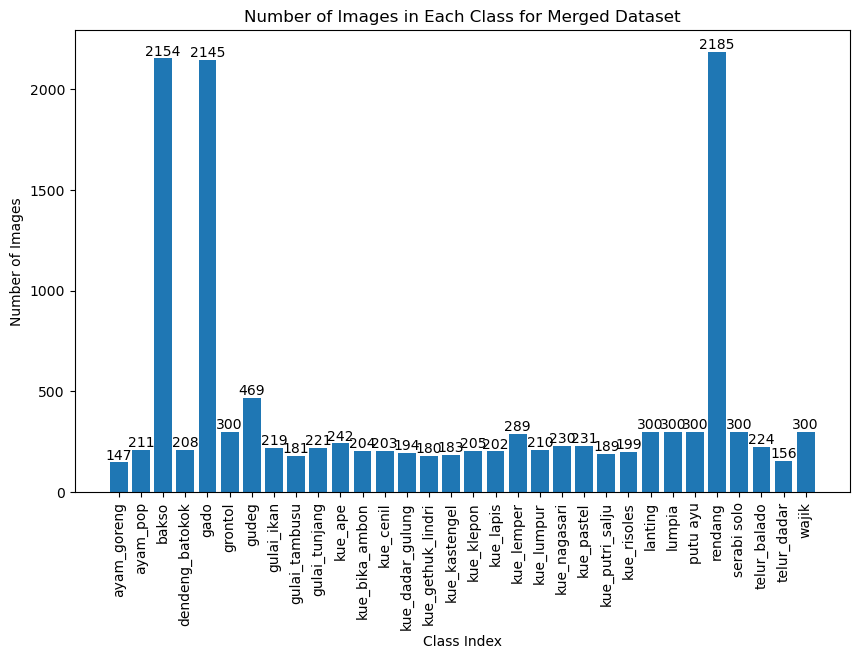

[]


In [11]:
def plot_dataset():
    class_names = os.listdir(dest_dir)
    new_num_images = []
    for class_name in class_names:
        class_path = os.path.join(dest_dir, class_name)
        new_num_images.append(len(os.listdir(class_path)))
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(class_names)), new_num_images)
    plt.title('Number of Images in Each Class for Merged Dataset')
    plt.xlabel('Class Index')
    plt.ylabel('Number of Images')
    plt.xticks(range(len(class_names)), class_names, rotation=90)
    for i, num_images in enumerate(new_num_images):
        plt.text(i, num_images, str(num_images), ha='center', va='bottom')

    plt.show()
    
plot_dataset()

for subfolder in os.listdir(dest_dir):
    subfolder_path = os.path.join(dest_dir, subfolder)
    if os.path.isdir(subfolder_path):
        webp_files = [file for file in os.listdir(subfolder_path) if  file.endswith('.webp') or file.endswith('.gif') or file.endswith('.jpe')]
        for webp_file in webp_files:
            if webp_file.endswith('.webp') or webp_file.endswith('.gif'):
                webp_path = os.path.join(subfolder_path, webp_file)
                jpg_file = f"{webp_file.split('.')[0]}.jpg"
                jpg_path = os.path.join(subfolder_path, jpg_file)
                with Image.open(webp_path) as im:
                    im.convert('RGB').save(jpg_path, 'JPEG')
                os.remove(webp_path)
            else:
                webp_path = os.path.join(subfolder_path, webp_file)
                os.remove(webp_path)
        
for subfolder in os.listdir(dest_dir):
    subfolder_path = os.path.join(dest_dir, subfolder)
    if os.path.isdir(subfolder_path):
        webp_files = [file for file in os.listdir(subfolder_path) if file.endswith('.webp') or file.endswith('.gif') or file.endswith('.jpe')]
print(webp_files)

min_num_images = 180
class_names = os.listdir(dest_dir)
for class_name in class_names:
    class_dir = os.path.join(dest_dir, class_name)
    num_images = len(os.listdir(class_dir))
    if num_images < min_num_images:
        shutil.rmtree(class_dir)
        class_names.remove(class_name)

for class_name in class_names:
    class_dir = os.path.join(dest_dir, class_name)
    image_files = os.listdir(class_dir)
    while len(image_files) > min_num_images:
        num_images_to_remove = len(image_files) - min_num_images
        random.shuffle(image_files)
        images_to_remove = image_files[:num_images_to_remove]
        for image_file in images_to_remove:
            image_path = os.path.join(class_dir, image_file)
            os.remove(image_path)
        image_files = os.listdir(class_dir)

In [12]:
threshold = 5000
outliers = data[data['runDistance'] > threshold]
data_cleaned = data[data['runDistance'] <= threshold]

## Exploratory Data Analysis (EDA)

              steps      distance  runDistance    calories
count    303.000000    303.000000   303.000000  303.000000
mean   10271.125413   7023.831683  1610.574257  235.250825
std     5495.113328   3840.953779  1403.338925  130.447332
min        0.000000      0.000000     0.000000    0.000000
25%     5766.500000   3857.500000   381.000000  127.000000
50%    10823.000000   7425.000000  1180.000000  248.000000
75%    14496.500000   9802.500000  2482.500000  332.000000
max    26184.000000  18045.000000  6561.000000  551.000000


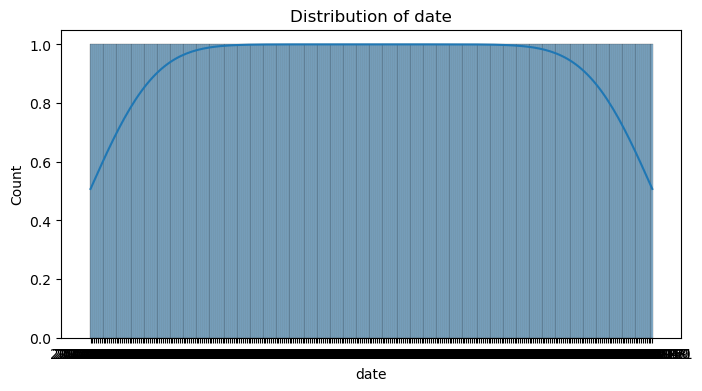

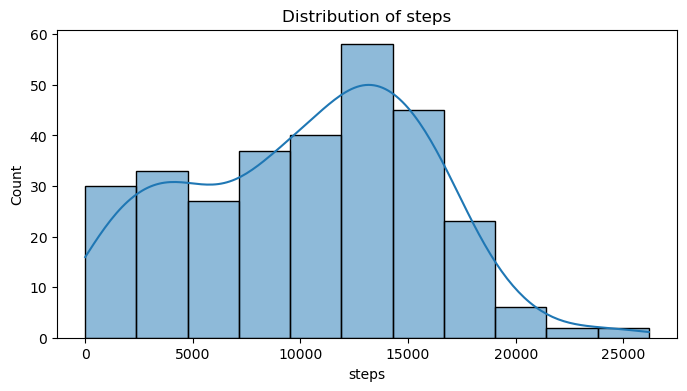

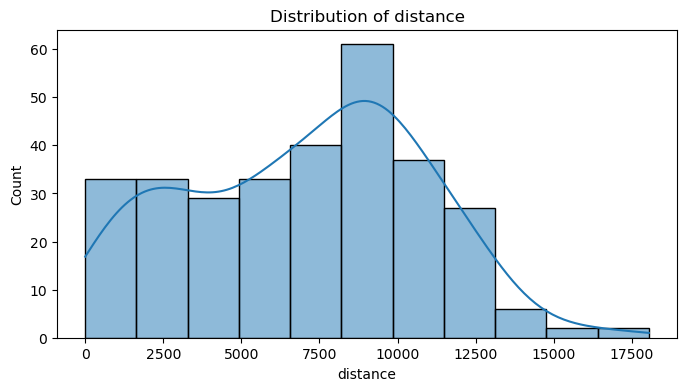

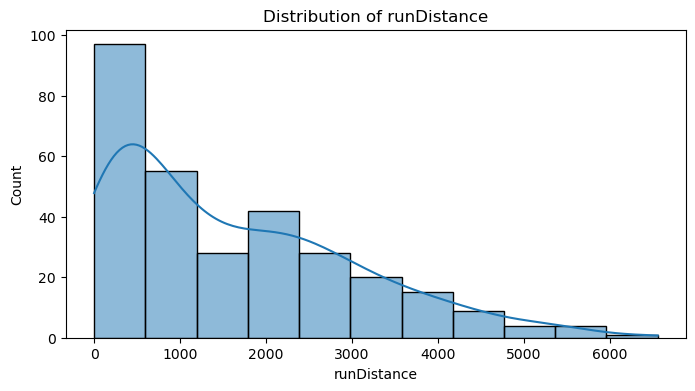

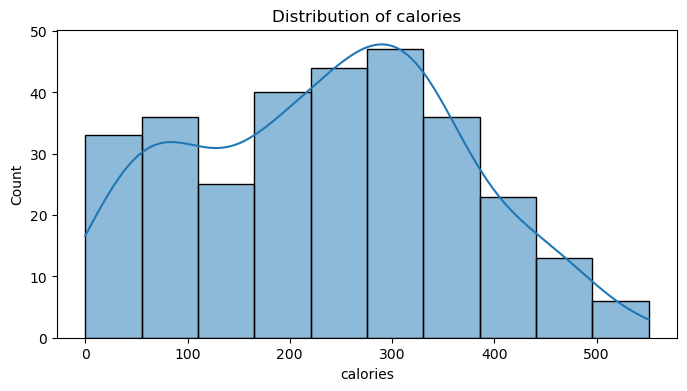

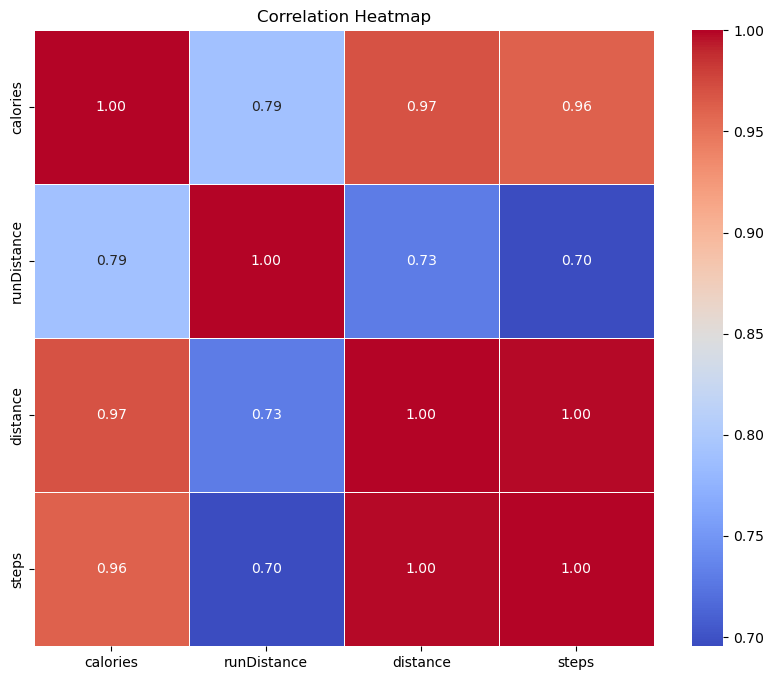

C:\Users\MaulanaRakha1\AppData\Roaming\Python\Python311\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


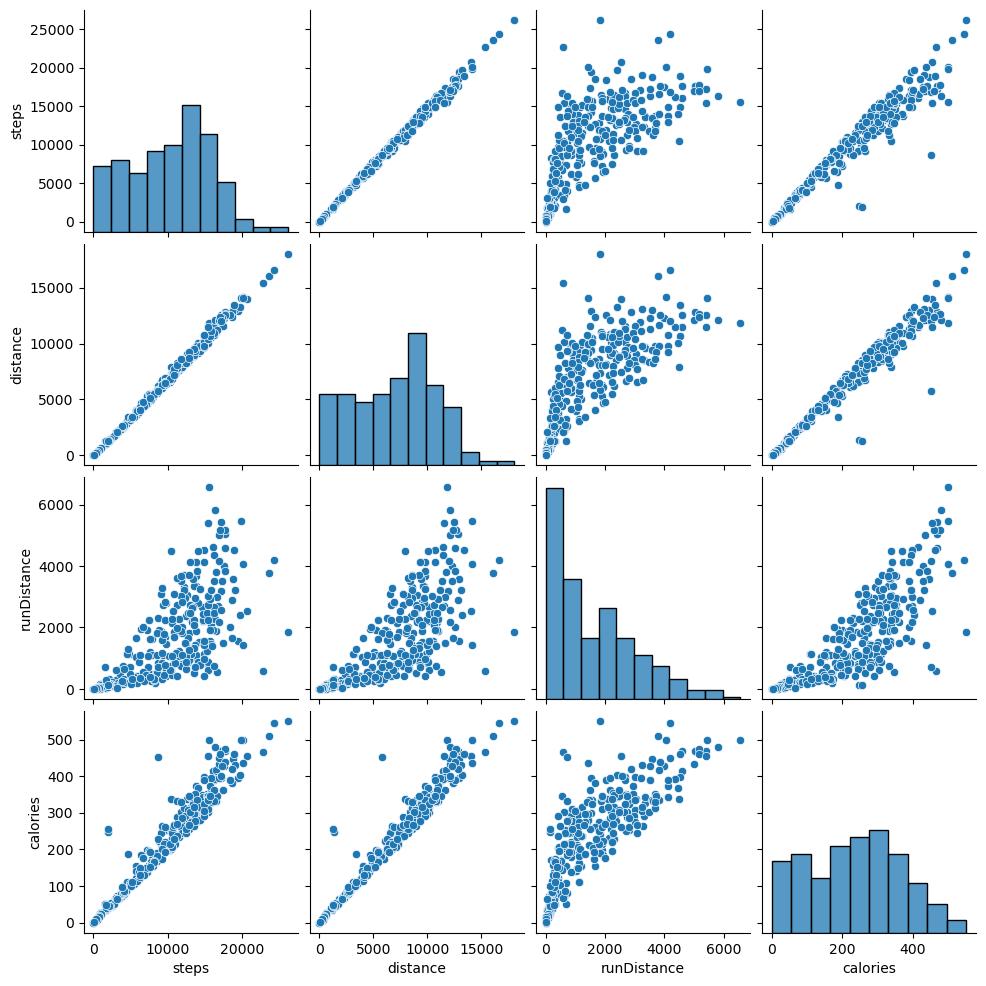

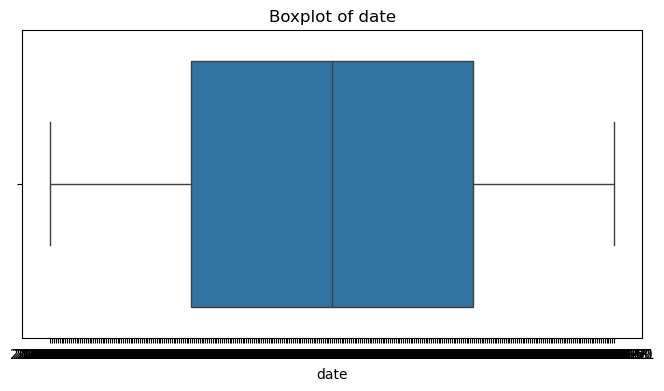

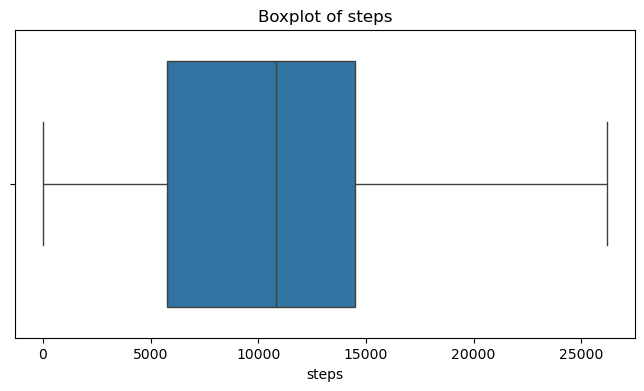

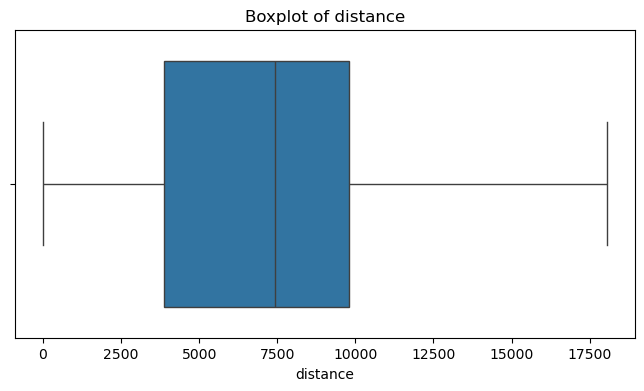

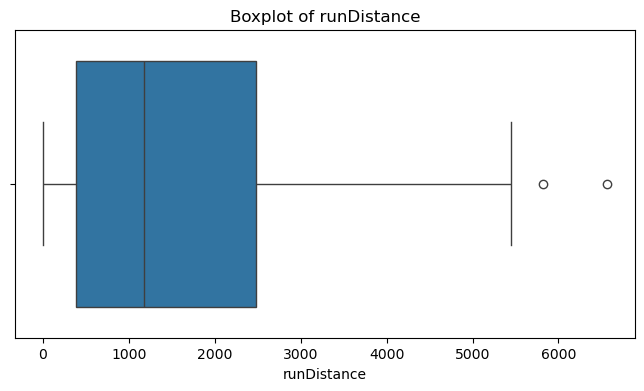

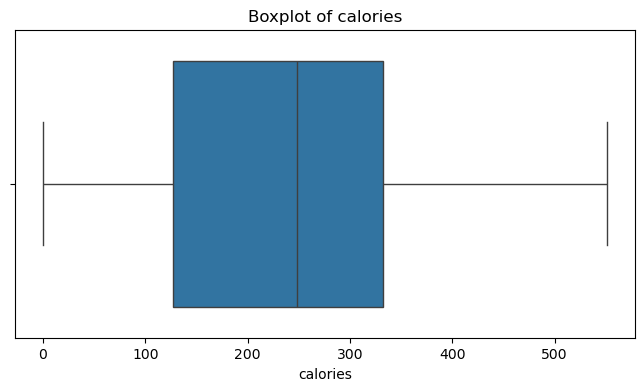

<Figure size 640x480 with 0 Axes>

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

print(data.describe())
for column in data.columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(data[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.show()

X = data_cleaned[['calories']]
y = data_cleaned[['runDistance', 'distance', 'steps']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

data_for_corr = pd.concat([X_train, y_train], axis=1)

corr_matrix = data_for_corr.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()
sns.pairplot(data)
plt.show()

for column in data.columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=data[column])
    plt.title(f'Boxplot of {column}')
    plt.show()

plt.tight_layout()
plt.show()

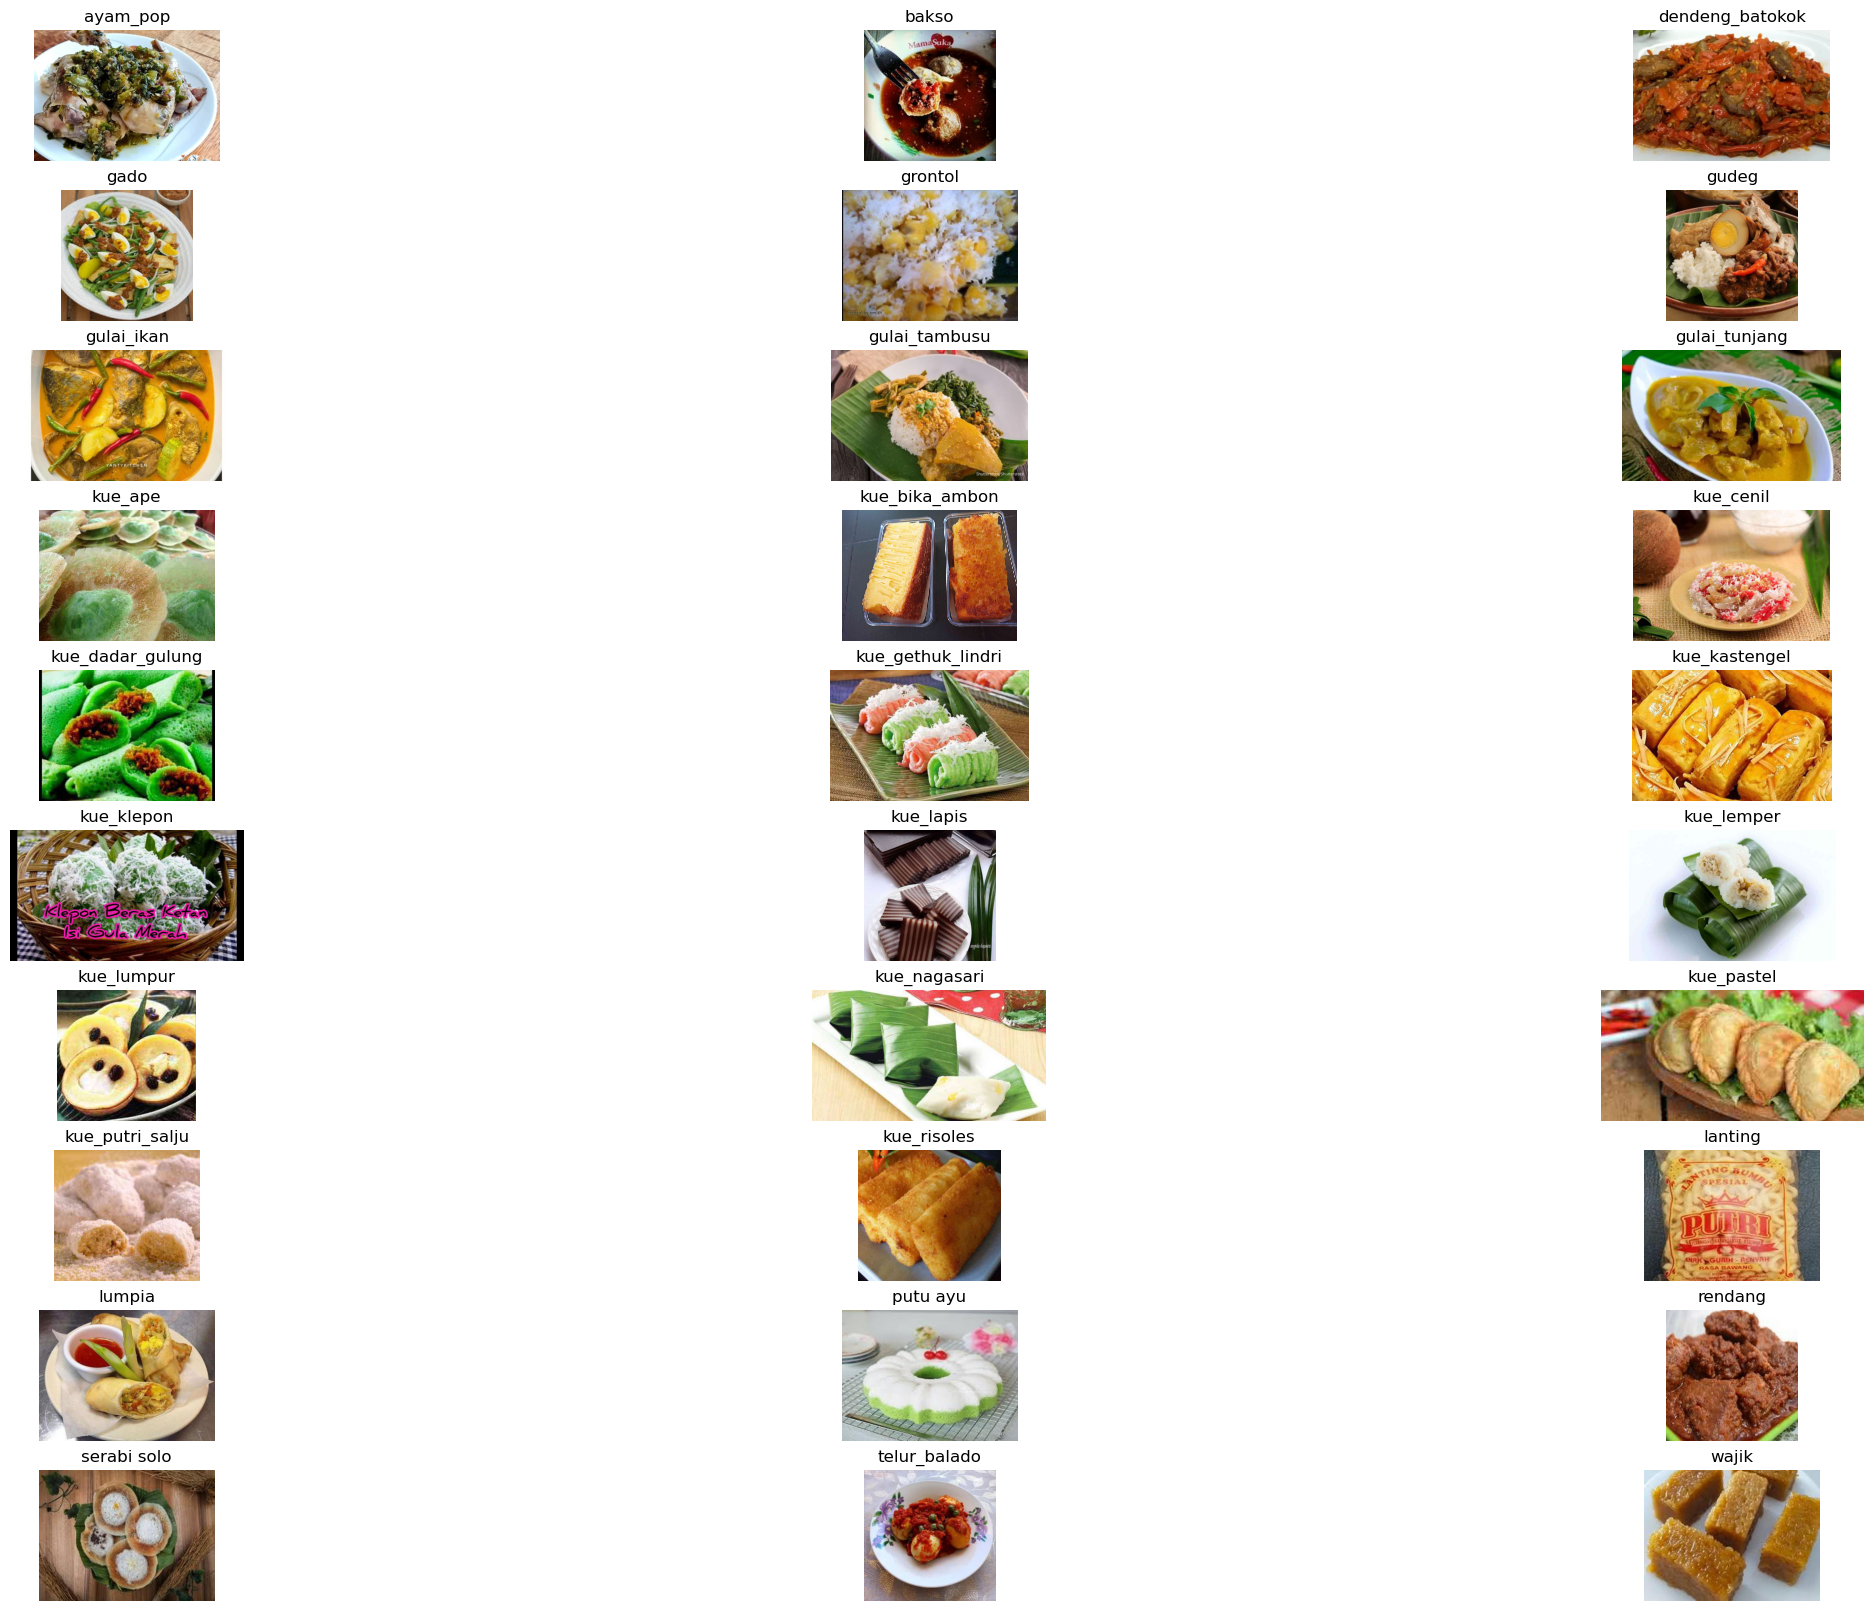

In [14]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Path to the directory containing subfolders
directory = './Merged_Dataset'


# Get a list of subfolders
subfolders = [f for f in os.listdir(directory) if os.path.isdir(os.path.join(directory, f))]

# Set up the subplots
num_subplots = len(subfolders)
num_cols = 3  # Number of columns in the subplot grid
num_rows = (num_subplots + num_cols - 1) // num_cols  # Number of rows in the subplot grid

fig, axes = plt.subplots(num_rows, num_cols, figsize=(24, 16), constrained_layout=True)

# Iterate over subfolders and plot one image from each
for i, folder in enumerate(subfolders):
    folder_path = os.path.join(directory, folder)
    
    # Get the first image file in each subfolder
    image_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg') or f.endswith('.png')]
    if len(image_files) > 0:
        image_path = os.path.join(folder_path, image_files[0])
        
        # Load the image
        image = Image.open(image_path)
        
        # Plot the image in the corresponding subplot
        row_idx = i // num_cols
        col_idx = i % num_cols
        axes[row_idx, col_idx].imshow(image)
        axes[row_idx, col_idx].set_title(folder)
        axes[row_idx, col_idx].axis('off')
        axes[row_idx, col_idx].set_aspect('equal')

# Remove empty subplots if necessary
if num_subplots < num_rows * num_cols:
    for i in range(num_subplots, num_rows * num_cols):
        row_idx = i // num_cols
        col_idx = i % num_cols
        fig.delaxes(axes[row_idx, col_idx])

# Adjust spacing between subplots
#plt.subplots_adjust(wspace=0.0025, hspace=0.5)
#plt.tight_layout()
plt.show()


## Visualization & Explanatory Analysis

### Pertanyaan 1:

## Membuat Model 

In [15]:
datagen = ImageDataGenerator()
filenames = datagen.flow_from_directory(
    dest_dir,
    shuffle=False,
    seed=42,
    classes=None
).filenames
actual_filenames = []
for root, dirs, files in os.walk(dest_dir):
    for file in files:
        actual_filenames.append(os.path.join(root, file))
for i, filename in enumerate(filenames):
    filenames[i] = str(os.path.join(dest_dir,filename))
undetected_filenames = set(actual_filenames) - set(filenames)
for filename in undetected_filenames:
    print(f"Undetected file: {filename}")

Found 5400 images belonging to 30 classes.


### Training Model

In [16]:
training_datagen = ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.3)


train_generator = training_datagen.flow_from_directory(
    dest_dir,
    target_size=(128,128),
    class_mode='categorical',
    batch_size=64,
    subset='training'
)

val_generator = training_datagen.flow_from_directory(
    dest_dir,
    target_size=(128,128),
    class_mode='categorical',
    batch_size=64,
    subset='validation'
)

pre_trained_model = MobileNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(128, 128, 3),
    alpha = 1,
    pooling='avg',
)
pre_trained_model.summary()

for layer in pre_trained_model.layers[:-4]:
    layer.trainable = False

last_layer = pre_trained_model.get_layer('global_average_pooling2d')
print('last layer output shape: ', last_layer.output_shape)

trainable_layers = [layer.name for layer in pre_trained_model.layers if layer.trainable]
print("Trainable Layers:")
for layer in trainable_layers:
    print(layer)
    
x = layers.Flatten()(last_layer.output)
x_train_list = []
y_train_list = []

x_val_list = []
y_val_list = []

for i in range(len(train_generator)):
    x_train_batch, y_train_batch = train_generator[i]
    x_train_list.append(x_train_batch)
    y_train_list.append(y_train_batch)

for i in range(len(val_generator)):
    x_val_batch, y_val_batch = val_generator[i]
    x_val_list.append(x_val_batch)
    y_val_list.append(y_val_batch)

x_train = np.concatenate(x_train_list)
y_train = np.concatenate(y_train_list)

x_val = np.concatenate(x_val_list)
y_val = np.concatenate(y_val_list)

x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.67, random_state=1)

print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_val shape:', x_val.shape)
print('y_val shape:', y_val.shape)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)

Found 3780 images belonging to 30 classes.
Found 1620 images belonging to 30 classes.


Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 64, 64, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 64, 64, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                          

                                                                                                  
 block_3_expand (Conv2D)     (None, 32, 32, 144)          3456      ['block_2_add[0][0]']         
                                                                                                  
 block_3_expand_BN (BatchNo  (None, 32, 32, 144)          576       ['block_3_expand[0][0]']      
 rmalization)                                                                                     
                                                                                                  
 block_3_expand_relu (ReLU)  (None, 32, 32, 144)          0         ['block_3_expand_BN[0][0]']   
                                                                                                  
 block_3_pad (ZeroPadding2D  (None, 33, 33, 144)          0         ['block_3_expand_relu[0][0]'] 
 )                                                                                                
          

 block_6_pad (ZeroPadding2D  (None, 17, 17, 192)          0         ['block_6_expand_relu[0][0]'] 
 )                                                                                                
                                                                                                  
 block_6_depthwise (Depthwi  (None, 8, 8, 192)            1728      ['block_6_pad[0][0]']         
 seConv2D)                                                                                        
                                                                                                  
 block_6_depthwise_BN (Batc  (None, 8, 8, 192)            768       ['block_6_depthwise[0][0]']   
 hNormalization)                                                                                  
                                                                                                  
 block_6_depthwise_relu (Re  (None, 8, 8, 192)            0         ['block_6_depthwise_BN[0][0]']
 LU)      

                                                                                                  
 block_9_project (Conv2D)    (None, 8, 8, 64)             24576     ['block_9_depthwise_relu[0][0]
                                                                    ']                            
                                                                                                  
 block_9_project_BN (BatchN  (None, 8, 8, 64)             256       ['block_9_project[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block_9_add (Add)           (None, 8, 8, 64)             0         ['block_8_add[0][0]',         
                                                                     'block_9_project_BN[0][0]']  
                                                                                                  
 block_10_

                                                                     'block_12_project_BN[0][0]'] 
                                                                                                  
 block_13_expand (Conv2D)    (None, 8, 8, 576)            55296     ['block_12_add[0][0]']        
                                                                                                  
 block_13_expand_BN (BatchN  (None, 8, 8, 576)            2304      ['block_13_expand[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block_13_expand_relu (ReLU  (None, 8, 8, 576)            0         ['block_13_expand_BN[0][0]']  
 )                                                                                                
                                                                                                  
 block_13_

 ormalization)                                                                                    
                                                                                                  
 block_16_expand_relu (ReLU  (None, 4, 4, 960)            0         ['block_16_expand_BN[0][0]']  
 )                                                                                                
                                                                                                  
 block_16_depthwise (Depthw  (None, 4, 4, 960)            8640      ['block_16_expand_relu[0][0]']
 iseConv2D)                                                                                       
                                                                                                  
 block_16_depthwise_BN (Bat  (None, 4, 4, 960)            3840      ['block_16_depthwise[0][0]']  
 chNormalization)                                                                                 
          

In [17]:
num_classes = y_train.shape[1]

def build_model(hp):
    train_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    validation_datagen = ImageDataGenerator()
    train_generator = train_datagen.flow(
        x_train,
        y=y_train,
        batch_size=64,
    )
    validation_generator = validation_datagen.flow(
        x_val,
        y=y_val,
        batch_size=64
    )
    last_output = last_layer.output
    x = layers.Dense(units=hp.Int('hidden_units', min_value=512, max_value=1024, step=512),
                     activation='relu',
                     kernel_regularizer=L2(hp.Float('regularization_strength', min_value=0, max_value=0.5, step=0.1)))(last_output)
    x = layers.Dropout(rate=hp.Float('dropout_rate', min_value=0, max_value=0.5, step=0.1))(x)
    x = layers.Dense(num_classes, activation='softmax')(x)
    model = Model(pre_trained_model.input, x)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=20,
    factor=3,
    directory='dest_dir',
    project_name='Hyperband_real'
)

stop_early = EarlyStopping(monitor='val_loss', patience=10)
tuner.search(x_train,y_train, epochs=30, validation_data=(x_val,y_val), callbacks=[stop_early])
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)
print(f"Optimal units: {best_hps.get('hidden_units')}, optimal dropout rate: {best_hps.get('dropout_rate')}, optimal learning rate: {best_hps.get('regularization_strength')}")

hidden_units = best_hps.get('hidden_units')
dropout_rate = best_hps.get('dropout_rate')
regularization_str = best_hps.get('regularization_strength')

Reloading Tuner from dest_dir\Hyperband_real\tuner0.json
Optimal units: 512, optimal dropout rate: 0.0, optimal learning rate: 0.30000000000000004


### Evaluasi Model

In [18]:
input_data = np.concatenate((x_train, x_val), axis=0)
target_data = np.concatenate((y_train, y_val), axis=0)
input_data.shape, target_data.shape

from sklearn.model_selection import KFold
# Perform k-fold cross-validation with a seed
kfold = KFold(n_splits=30, shuffle=True, random_state=42)  # Update the number of splits and the random seed as needed

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

fold_no = 0
acc_per_fold = []
loss_per_fold = []
x_train_list =[]
y_train_list =[]
x_val_list =[]
y_val_list = []
best_accuracy = 0.0

val_acc_per_fold = []  # Add a list to store validation accuracy
for train_index, val_index in kfold.split(input_data):
    x_train_fold, y_train_fold = input_data[train_index], target_data[train_index]
    x_val_fold, y_val_fold = input_data[val_index], target_data[val_index]
    # Create an ImageDataGenerator for training data
    train_datagen = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest')

    # Create an ImageDataGenerator for validation data
    validation_datagen = ImageDataGenerator()

    # Generate batches of augmented data for training
    train_generator = train_datagen.flow(
        x_train_fold,
        y = y_train_fold,
        batch_size=64,
    )

    # Generate batches of data for validation
    validation_generator = validation_datagen.flow(
        x_val_fold,
        y = y_val_fold,
        batch_size=64
    )

    last_output = last_layer.output
    # Add a fully connected layer with 1,024 hidden units and ReLU activation
    x = layers.Dense(hidden_units, activation='relu', kernel_regularizer=L2(regularization_str))(last_output)
    # Add a dropout
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(pre_trained_model.input, x)
    #model.summary()
    

    # Print the shape of the current fold's training and validation data
    print('Training data shape:', x_train_fold.shape, y_train_fold.shape)
    print('Validation data shape:', x_val_fold.shape, y_val_fold.shape)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    
    # Train the model on the current fold's data
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)
    history = model.fit(train_generator,
              validation_data=validation_generator,
              epochs=50,
              callbacks=[early_stop])  # Update the number of epochs as needed

    # Generate generalization metrics
    test_loss, test_accuracy = model.evaluate(x_test, y_test)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {test_loss}; {model.metrics_names[1]} of {test_accuracy*100}%')
    acc_per_fold.append(test_accuracy * 100)
    loss_per_fold.append(test_loss)
    test_last_fold=acc_per_fold[fold_no]
    print(f'test acuraccy : {acc_per_fold[fold_no]} for fold {fold_no}')
    
    val_acc_per_fold.append(max(history.history['val_accuracy']))  # Add the maximum validation accuracy to the list
    x_train_list.append(x_train_fold)
    y_train_list.append(y_train_fold)
    
    x_val_list.append(x_val_fold)
    y_val_list.append(y_val_fold)
    
    # Check if this model has the best accuracy so far
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        best_model = model
        best_fold = fold_no
    # Increase fold number
    fold_no = fold_no + 1
    
print(f'best_accuracy : {best_accuracy}\nbest_model : {best_model}\nbest_fold :{best_fold}')

print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
# Print the validation accuracy for each fold
for i, val_acc in enumerate(val_acc_per_fold):
    print(f'Validation accuracy for fold {i+1}: {val_acc * 100}%')
print('------------------------------------------------------------------------')

Training data shape: (4170, 128, 128, 3) (4170, 30)
Validation data shape: (144, 128, 128, 3) (144, 30)
------------------------------------------------------------------------
Training for fold 0 ...
Epoch 1/50


66/66 [==============================] - 43s 553ms/step - loss: 189.3090 - accuracy: 0.2070 - val_loss: 158.2420 - val_accuracy: 0.3403
Epoch 2/50
66/66 [==============================] - 37s 557ms/step - loss: 133.5697 - accuracy: 0.5494 - val_loss: 110.9960 - val_accuracy: 0.5972
Epoch 3/50
66/66 [==============================] - 37s 557ms/step - loss: 93.5793 - accuracy: 0.6751 - val_loss: 77.1200 - val_accuracy: 0.6597
Epoch 4/50
66/66 [==============================] - 37s 560ms/step - loss: 64.6547 - accuracy: 0.7297 - val_loss: 52.9778 - val_accuracy: 0.6736
Epoch 5/50
66/66 [==============================] - 38s 569ms/step - loss: 44.1985 - accuracy: 0.7520 - val_loss: 36.0455 - val_accuracy: 0.7014
Epoch 6/50
66/66 [==============================] - 38s 571ms/step -

Epoch 1/50
66/66 [==============================] - 35s 466ms/step - loss: 189.5917 - accuracy: 0.3839 - val_loss: 158.0967 - val_accuracy: 0.7500
Epoch 2/50
66/66 [==============================] - 30s 452ms/step - loss: 133.8707 - accuracy: 0.7669 - val_loss: 110.9103 - val_accuracy: 0.8333
Epoch 3/50
66/66 [==============================] - 30s 451ms/step - loss: 93.5965 - accuracy: 0.8189 - val_loss: 76.9506 - val_accuracy: 0.8472
Epoch 4/50
66/66 [==============================] - 30s 458ms/step - loss: 64.3591 - accuracy: 0.8432 - val_loss: 52.7384 - val_accuracy: 0.8611
Epoch 5/50
66/66 [==============================] - 30s 451ms/step - loss: 44.0526 - accuracy: 0.8501 - val_loss: 35.6744 - val_accuracy: 0.8750
Epoch 6/50
66/66 [==============================] - 30s 452ms/step - loss: 29.6772 - accuracy: 0.8535 - val_loss: 23.8223 - val_accuracy: 0.8750
Epoch 7/50
66/66 [==============================] - 30s 450ms/step - loss: 19.7531 - accuracy: 0.8638 - val_loss: 15.7357 - va

Epoch 7/50
66/66 [==============================] - 35s 533ms/step - loss: 19.7624 - accuracy: 0.8700 - val_loss: 15.8622 - val_accuracy: 0.8819
Epoch 8/50
66/66 [==============================] - 35s 526ms/step - loss: 13.0215 - accuracy: 0.8751 - val_loss: 10.4074 - val_accuracy: 0.8750
Epoch 9/50
66/66 [==============================] - 38s 581ms/step - loss: 8.5232 - accuracy: 0.8779 - val_loss: 6.8425 - val_accuracy: 0.8611
Epoch 10/50
66/66 [==============================] - 41s 611ms/step - loss: 5.6130 - accuracy: 0.8772 - val_loss: 4.5132 - val_accuracy: 0.8681
Epoch 11/50
66/66 [==============================] - 38s 570ms/step - loss: 3.7270 - accuracy: 0.8882 - val_loss: 3.0333 - val_accuracy: 0.8889
Epoch 12/50
66/66 [==============================] - 42s 632ms/step - loss: 2.5438 - accuracy: 0.8859 - val_loss: 2.1231 - val_accuracy: 0.8750
Epoch 13/50
66/66 [==============================] - 33s 500ms/step - loss: 1.8135 - accuracy: 0.8873 - val_loss: 1.5915 - val_accuracy

66/66 [==============================] - 38s 567ms/step - loss: 0.8020 - accuracy: 0.8861 - val_loss: 0.7551 - val_accuracy: 0.8750
Epoch 20/50
66/66 [==============================] - 48s 721ms/step - loss: 0.7701 - accuracy: 0.8914 - val_loss: 0.7578 - val_accuracy: 0.8819
Epoch 21/50
66/66 [==============================] - 46s 697ms/step - loss: 0.7694 - accuracy: 0.8887 - val_loss: 0.7333 - val_accuracy: 0.8889
Epoch 22/50
66/66 [==============================] - 41s 620ms/step - loss: 0.7406 - accuracy: 0.9002 - val_loss: 0.7620 - val_accuracy: 0.8681
Epoch 23/50
66/66 [==============================] - 42s 633ms/step - loss: 0.7364 - accuracy: 0.8998 - val_loss: 0.7186 - val_accuracy: 0.8681
Epoch 24/50
66/66 [==============================] - 40s 603ms/step - loss: 0.7363 - accuracy: 0.8928 - val_loss: 0.7456 - val_accuracy: 0.8681
Epoch 25/50
66/66 [==============================] - 37s 564ms/step - loss: 0.7389 - accuracy: 0.8981 - val_loss: 0.7350 - val_accuracy: 0.8611
Epoc

66/66 [==============================] - 32s 488ms/step - loss: 1.3282 - accuracy: 0.9019 - val_loss: 1.0993 - val_accuracy: 0.9097
Epoch 15/50
66/66 [==============================] - 32s 489ms/step - loss: 1.0655 - accuracy: 0.8962 - val_loss: 0.9348 - val_accuracy: 0.8889
Epoch 16/50
66/66 [==============================] - 40s 599ms/step - loss: 0.9198 - accuracy: 0.8971 - val_loss: 0.7997 - val_accuracy: 0.8958
Epoch 17/50
34/34 [==============================] - 6s 171ms/step - loss: 1.0847 - accuracy: 0.8048
Score for fold 7: loss of 1.0846749544143677; accuracy of 80.47882318496704%
test acuraccy : 80.47882318496704 for fold 7
Training data shape: (4170, 128, 128, 3) (4170, 30)
Validation data shape: (144, 128, 128, 3) (144, 30)
------------------------------------------------------------------------
Training for fold 8 ...
Epoch 1/50
66/66 [==============================] - 41s 560ms/step - loss: 189.6570 - accuracy: 0.4595 - val_loss: 158.1734 - val_accuracy: 0.8542
Epoch 2/5

66/66 [==============================] - 35s 533ms/step - loss: 0.6734 - accuracy: 0.9031 - val_loss: 0.6834 - val_accuracy: 0.8819
Epoch 28/50
66/66 [==============================] - 35s 533ms/step - loss: 0.6613 - accuracy: 0.9067 - val_loss: 0.6418 - val_accuracy: 0.8958
Epoch 29/50
66/66 [==============================] - 36s 540ms/step - loss: 0.6621 - accuracy: 0.9091 - val_loss: 0.6727 - val_accuracy: 0.8889
Epoch 30/50
34/34 [==============================] - 5s 159ms/step - loss: 0.9222 - accuracy: 0.8085
Score for fold 9: loss of 0.9221501350402832; accuracy of 80.84714412689209%
test acuraccy : 80.84714412689209 for fold 9
Training data shape: (4170, 128, 128, 3) (4170, 30)
Validation data shape: (144, 128, 128, 3) (144, 30)
------------------------------------------------------------------------
Training for fold 10 ...
Epoch 1/50
66/66 [==============================] - 44s 571ms/step - loss: 189.9687 - accuracy: 0.4743 - val_loss: 158.4597 - val_accuracy: 0.8819
Epoch 2/

Training data shape: (4170, 128, 128, 3) (4170, 30)
Validation data shape: (144, 128, 128, 3) (144, 30)
------------------------------------------------------------------------
Training for fold 12 ...
Epoch 1/50
66/66 [==============================] - 54s 684ms/step - loss: 190.0324 - accuracy: 0.4911 - val_loss: 158.1326 - val_accuracy: 0.8194
Epoch 2/50
66/66 [==============================] - 38s 580ms/step - loss: 133.9502 - accuracy: 0.8245 - val_loss: 111.0996 - val_accuracy: 0.8958
Epoch 3/50
66/66 [==============================] - 39s 592ms/step - loss: 93.6424 - accuracy: 0.8621 - val_loss: 77.1311 - val_accuracy: 0.8958
Epoch 4/50
66/66 [==============================] - 36s 536ms/step - loss: 64.7288 - accuracy: 0.8748 - val_loss: 52.8299 - val_accuracy: 0.9097
Epoch 5/50
66/66 [==============================] - 46s 700ms/step - loss: 44.1974 - accuracy: 0.8775 - val_loss: 35.7029 - val_accuracy: 0.9306
Epoch 6/50
66/66 [==============================] - 42s 641ms/step - 

66/66 [==============================] - 40s 599ms/step - loss: 29.6701 - accuracy: 0.8921 - val_loss: 23.9584 - val_accuracy: 0.8611
Epoch 7/50
66/66 [==============================] - 36s 540ms/step - loss: 19.7211 - accuracy: 0.9034 - val_loss: 15.8175 - val_accuracy: 0.8819
Epoch 8/50
66/66 [==============================] - 41s 620ms/step - loss: 12.9742 - accuracy: 0.8950 - val_loss: 10.3354 - val_accuracy: 0.8542
Epoch 9/50
66/66 [==============================] - 38s 564ms/step - loss: 8.4589 - accuracy: 0.9029 - val_loss: 6.7267 - val_accuracy: 0.8819
Epoch 10/50
66/66 [==============================] - 42s 637ms/step - loss: 5.5017 - accuracy: 0.9050 - val_loss: 4.3803 - val_accuracy: 0.8611
Epoch 11/50
66/66 [==============================] - 39s 582ms/step - loss: 3.6220 - accuracy: 0.9019 - val_loss: 2.9079 - val_accuracy: 0.8611
Epoch 12/50
66/66 [==============================] - 39s 598ms/step - loss: 2.4319 - accuracy: 0.9108 - val_loss: 2.0022 - val_accuracy: 0.8681
E

66/66 [==============================] - 39s 592ms/step - loss: 5.5029 - accuracy: 0.9125 - val_loss: 4.3515 - val_accuracy: 0.8819
Epoch 11/50
66/66 [==============================] - 39s 582ms/step - loss: 3.6080 - accuracy: 0.9156 - val_loss: 2.8702 - val_accuracy: 0.9167
Epoch 12/50
66/66 [==============================] - 37s 564ms/step - loss: 2.4357 - accuracy: 0.9050 - val_loss: 1.9368 - val_accuracy: 0.9236
Epoch 13/50
66/66 [==============================] - 38s 571ms/step - loss: 1.7060 - accuracy: 0.9086 - val_loss: 1.3810 - val_accuracy: 0.9097
Epoch 14/50
66/66 [==============================] - 37s 554ms/step - loss: 1.2645 - accuracy: 0.9019 - val_loss: 1.0055 - val_accuracy: 0.9236
Epoch 15/50
66/66 [==============================] - 36s 550ms/step - loss: 1.0039 - accuracy: 0.9062 - val_loss: 0.8629 - val_accuracy: 0.9167
Epoch 16/50
66/66 [==============================] - 36s 544ms/step - loss: 0.8452 - accuracy: 0.9134 - val_loss: 0.7468 - val_accuracy: 0.9167
Epoc

66/66 [==============================] - 52s 783ms/step - loss: 0.6912 - accuracy: 0.9060 - val_loss: 0.6046 - val_accuracy: 0.9306
Epoch 20/50
66/66 [==============================] - 46s 690ms/step - loss: 0.6639 - accuracy: 0.9132 - val_loss: 0.5606 - val_accuracy: 0.9375
Epoch 21/50
66/66 [==============================] - 43s 647ms/step - loss: 0.6635 - accuracy: 0.9115 - val_loss: 0.5832 - val_accuracy: 0.9236
Epoch 22/50
66/66 [==============================] - 39s 589ms/step - loss: 0.6397 - accuracy: 0.9177 - val_loss: 0.5665 - val_accuracy: 0.9236
Epoch 23/50
66/66 [==============================] - 39s 585ms/step - loss: 0.6516 - accuracy: 0.9118 - val_loss: 0.5475 - val_accuracy: 0.9375
Epoch 24/50
66/66 [==============================] - 40s 612ms/step - loss: 0.6455 - accuracy: 0.9113 - val_loss: 0.6036 - val_accuracy: 0.8889
Epoch 25/50
66/66 [==============================] - 37s 561ms/step - loss: 0.6415 - accuracy: 0.9146 - val_loss: 0.5895 - val_accuracy: 0.9236
Epoc

66/66 [==============================] - 36s 487ms/step - loss: 190.3007 - accuracy: 0.4945 - val_loss: 159.1560 - val_accuracy: 0.8194
Epoch 2/50
66/66 [==============================] - 31s 467ms/step - loss: 134.8228 - accuracy: 0.8369 - val_loss: 112.0577 - val_accuracy: 0.8542
Epoch 3/50
66/66 [==============================] - 31s 466ms/step - loss: 94.5520 - accuracy: 0.8743 - val_loss: 77.9095 - val_accuracy: 0.8611
Epoch 4/50
66/66 [==============================] - 31s 467ms/step - loss: 65.2689 - accuracy: 0.8875 - val_loss: 53.4643 - val_accuracy: 0.8889
Epoch 5/50
66/66 [==============================] - 31s 474ms/step - loss: 44.5153 - accuracy: 0.8957 - val_loss: 36.2126 - val_accuracy: 0.8750
Epoch 6/50
66/66 [==============================] - 31s 466ms/step - loss: 30.0166 - accuracy: 0.9024 - val_loss: 24.1818 - val_accuracy: 0.9097
Epoch 7/50
66/66 [==============================] - 31s 465ms/step - loss: 19.9216 - accuracy: 0.9074 - val_loss: 15.9660 - val_accuracy:

Epoch 15/50
66/66 [==============================] - 31s 468ms/step - loss: 0.9849 - accuracy: 0.9129 - val_loss: 0.8856 - val_accuracy: 0.8750
Epoch 16/50
34/34 [==============================] - 5s 144ms/step - loss: 1.0818 - accuracy: 0.8103
Score for fold 23: loss of 1.0817594528198242; accuracy of 81.03130459785461%
test acuraccy : 81.03130459785461 for fold 23
Training data shape: (4171, 128, 128, 3) (4171, 30)
Validation data shape: (143, 128, 128, 3) (143, 30)
------------------------------------------------------------------------
Training for fold 24 ...
Epoch 1/50
66/66 [==============================] - 36s 485ms/step - loss: 190.1062 - accuracy: 0.4785 - val_loss: 158.5351 - val_accuracy: 0.7762
Epoch 2/50
66/66 [==============================] - 31s 470ms/step - loss: 134.0641 - accuracy: 0.8223 - val_loss: 111.7137 - val_accuracy: 0.8322
Epoch 3/50
66/66 [==============================] - 31s 464ms/step - loss: 93.9153 - accuracy: 0.8619 - val_loss: 77.6570 - val_accurac

66/66 [==============================] - 31s 461ms/step - loss: 5.5389 - accuracy: 0.9063 - val_loss: 4.3389 - val_accuracy: 0.9021
Epoch 11/50
66/66 [==============================] - 31s 463ms/step - loss: 3.6390 - accuracy: 0.9089 - val_loss: 2.8892 - val_accuracy: 0.8951
Epoch 12/50
66/66 [==============================] - 31s 462ms/step - loss: 2.4230 - accuracy: 0.9101 - val_loss: 1.9434 - val_accuracy: 0.9091
Epoch 13/50
66/66 [==============================] - 31s 463ms/step - loss: 1.6825 - accuracy: 0.9146 - val_loss: 1.3792 - val_accuracy: 0.8811
Epoch 14/50
66/66 [==============================] - 31s 461ms/step - loss: 1.2543 - accuracy: 0.9075 - val_loss: 1.0203 - val_accuracy: 0.9161
Epoch 15/50
66/66 [==============================] - 31s 462ms/step - loss: 0.9897 - accuracy: 0.9120 - val_loss: 0.8768 - val_accuracy: 0.8881
Epoch 16/50
66/66 [==============================] - 31s 463ms/step - loss: 0.8299 - accuracy: 0.9127 - val_loss: 0.8007 - val_accuracy: 0.8811
Epoc

34/34 [==============================] - 5s 151ms/step - loss: 1.1721 - accuracy: 0.8131
Score for fold 28: loss of 1.1720918416976929; accuracy of 81.30754828453064%
test acuraccy : 81.30754828453064 for fold 28
Training data shape: (4171, 128, 128, 3) (4171, 30)
Validation data shape: (143, 128, 128, 3) (143, 30)
------------------------------------------------------------------------
Training for fold 29 ...
Epoch 1/50
66/66 [==============================] - 37s 493ms/step - loss: 190.2956 - accuracy: 0.5042 - val_loss: 159.0580 - val_accuracy: 0.8322
Epoch 2/50
66/66 [==============================] - 37s 565ms/step - loss: 134.8439 - accuracy: 0.8252 - val_loss: 112.0656 - val_accuracy: 0.8951
Epoch 3/50
66/66 [==============================] - 35s 532ms/step - loss: 94.5058 - accuracy: 0.8602 - val_loss: 77.9193 - val_accuracy: 0.9301
Epoch 4/50
66/66 [==============================] - 33s 500ms/step - loss: 65.5005 - accuracy: 0.8837 - val_loss: 53.4443 - val_accuracy: 0.9650
E

### Menyimpan Model

34/34 [==============================] - 7s 155ms/step


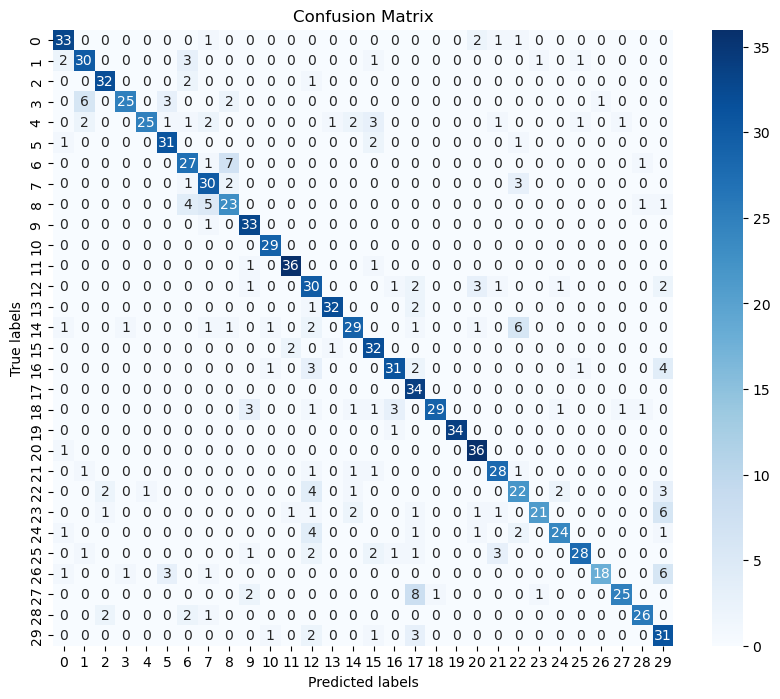

C:\Users\MaulanaRakha1\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [19]:
y_pred = np.argmax(best_model.predict(x_test), axis=1)
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

best_model.save('model_classifier.h5')
best_model.save('my_model.keras')

### Pertanyaan 2:

## Membuat Model 

In [37]:
threshold = 5000
outliers = data[data['runDistance'] > threshold]
data_cleaned = data[data['runDistance'] <= threshold]
X = data_cleaned[['calories']]
y = data_cleaned[['runDistance', 'distance', 'steps']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

ridge_model = Ridge()
ridge_model.fit(X_train_scaled, y_train)

rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train_scaled, y_train)

gb_model_multioutput = MultiOutputRegressor(GradientBoostingRegressor(random_state=42))
gb_model_multioutput.fit(X_train_scaled, y_train)

MultiOutputRegressor(estimator=GradientBoostingRegressor(random_state=42))

### Training Model

In [38]:
svr_model = SVR()

param_grid_svr = {'estimator__C': [0.1, 1, 10], 'estimator__epsilon': [0.01, 0.1, 1]}

svr_multioutput = MultiOutputRegressor(SVR())

grid_search_svr = GridSearchCV(svr_multioutput, param_grid_svr, scoring='r2', cv=5)
grid_search_svr.fit(X_train_scaled, y_train)

best_svr_model = grid_search_svr.best_estimator_

### Evaluasi Model

In [39]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred, multioutput='variance_weighted')
    return r2

r2_rf = evaluate_model(rf_model, X_test_scaled, y_test)
r2_gb = evaluate_model(gb_model_multioutput, X_test_scaled, y_test)

print({'Ridge Regression': r2_ridge, 'Random Forest': r2_rf, 'Gradient Boosting': r2_gb})

def predict_distances_steps(model, calories):
    input_data = scaler.transform([[calories]])
    predicted_values = model.predict(input_data)
    return predicted_values

best_model = max((ridge_model, r2_ridge), (rf_model, r2_rf), (gb_model_multioutput, r2_gb), key=lambda pair: pair[1])[0]

calories_input = float(input("Enter the number of calories burned: "))
input_array = scaler.transform([[calories_input]])  # Using array directly
predicted_values = best_model.predict(input_array)
print(f"Predicted running distance: {predicted_values[0][0]} meters")
print(f"Predicted walking distance: {predicted_values[0][1]} meters")
print(f"Predicted number of steps: {int(predicted_values[0][2])}")

{'Ridge Regression': 0.9430575376509754, 'Random Forest': 0.9027078382395088, 'Gradient Boosting': 0.8748764024460991}
Enter the number of calories burned: 100
Predicted running distance: 501.8596570607639 meters
Predicted walking distance: 3102.5446406691076 meters
Predicted number of steps: 4690


C:\Users\MaulanaRakha1\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


## Menyimpan Model

In [35]:
pip install joblib


^C
Note: you may need to restart the kernel to use updated packages.


In [41]:
best_model.save('model_classifier2.h5')
best_model.save('my_model2.keras')

## Conclusion

- Conclution pertanyaan 1
- Conclution pertanyaan 2